## References:
### Chinese Medicinal Material:
- [中藥材圖像數據庫](https://library.hkbu.edu.hk/electronic/libdbs/mmd/index.html)
- [衛生署中醫藥規管辦公室](https://www.cmro.gov.hk/html/b5/useful_information/hkcmms/index.html)
### Thesis:
- [Medicinal Plant Identification in Real-Time Using Deep Learning Model](https://link.springer.com/article/10.1007/s42979-023-02398-5)
- [Image recognition of traditional Chinese medicine based on deep learning](https://www.frontiersin.org/articles/10.3389/fbioe.2023.1199803/full)
- [An easy method for identifying 315 categories of commonly-used Chinese herbal medicines based on automated image recognition using AutoML platforms](https://www.sciencedirect.com/science/article/pii/S2352914821000976)
### Dataset:
- For practice:
    - [Flower Classification](https://www.kaggle.com/datasets/marquis03/flower-classification)
    - [Medicinal Plant Dataset (Augmented)](https://www.kaggle.com/datasets/vishnuoum/medicinal-plant-dataset-augmented/data)
- For objects other than the targets:
    - [COCO (Common Objects in Context)](https://cocodataset.org/#home)
### Algorithm:
- [Convolutional Neural Networks](https://ithelp.ithome.com.tw/articles/10262751)

## Import Libraries

In [1]:
# from tflite_model_maker import model_spec
# from tflite_model_maker import image_classifier
# from tflite_model_maker.config import ExportFormat
# from tflite_model_maker.config import QuantizationConfig
# from tflite_model_maker.image_classifier import DataLoader

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
# assert tf.__version__.startswith('2')

# plot_model
# pip install pydot
# pip install pydotplus
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

# pip install scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import os, random, shutil, warnings, cv2  # pip install opencv-python
warnings.filterwarnings('ignore')

## Train Test Split

In [3]:
train_path = os.path.join('input', 'train')
test_path = os.path.join('input', 'test')
# if not os.path.isdir(test_path):
#     os.makedirs(test_path)

In [4]:
# files_dict = {}
# dirs = os.walk(train_path)
# next(dirs)
# for dirname, _, filenames in dirs:
#     target_path = os.path.join(test_path, os.path.basename(dirname))
#     if not os.path.isdir(target_path):
#         os.makedirs(target_path)
#     herb_type = []
#     for filename in filenames:
#         herb_type.append(os.path.join(dirname, filename))
#     files_dict[target_path] = herb_type

In [5]:
# for path, arr in files_dict.items():
#     files_move = random.sample(arr, int(len(arr) * 0.1))
#     for file in files_move:
#         shutil.move(file, path)

## Data Exploration

In [6]:
pd.DataFrame(zip(os.listdir(train_path), os.listdir(test_path)), columns=['Species_Train', 'Species_Test'])

,Species_Train,Species_Test
0,Chantui,Chantui
1,Chuanbeimu,Chuanbeimu
2,Jinchantui,Jinchantui
3,Lingxiaohua,Lingxiaohua
4,Pingbeimu,Pingbeimu
5,Unknown,Unknown
6,Yangjinhua,Yangjinhua


## Visualization

In [7]:
files = []
for dirname, _, filenames in os.walk(train_path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
np.random.shuffle(files)

label = [os.path.basename(os.path.dirname(path)) for path in files]
df = pd.DataFrame(zip(files, label), columns=['Image', 'Label'])

<Axes: xlabel='Label', ylabel='count'>

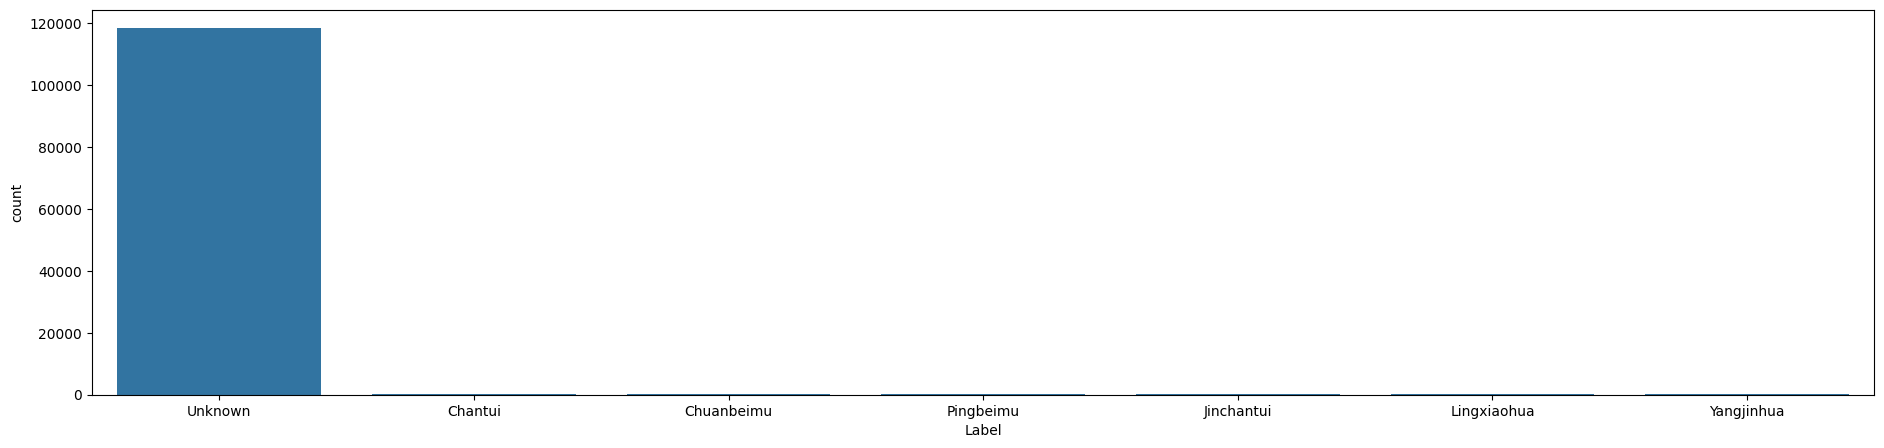

In [8]:
plt.figure(figsize=(23, 5))
sns.countplot(x=df['Label'])#.set_title('Train')

## Split Dataset

In [9]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='training',
    seed=666,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='validation',
    seed=666,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 120091 files belonging to 7 classes.
Using 96073 files for training.
Found 120091 files belonging to 7 classes.
Using 24018 files for validation.


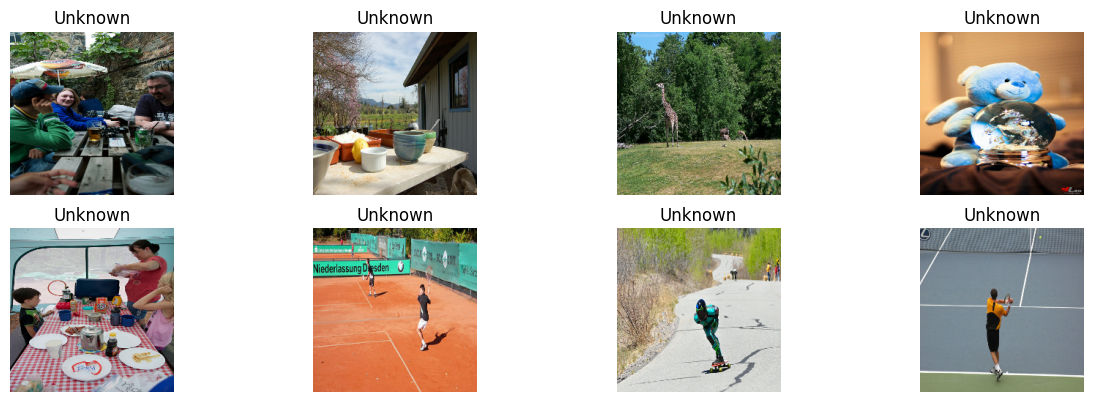

In [10]:
plt.figure(figsize=(15, 20))
for images, labels in train_data.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_data.class_names[labels[i]])
        plt.axis('off')

## Modeling

### MobileNetV3Large

In [11]:
num_classes = len(train_data.class_names)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

keras_model = tf.keras.models.Sequential([
    # Preprocessing layers
    tf.keras.layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    
    # MobileNetV3Large
    base_model,
    
    # Dropout layer
    tf.keras.layers.Dropout(0.2),
    
    # Flatten layer
    tf.keras.layers.Flatten(),
    
    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
keras_model.build((None, img_height, img_width, 3))
keras_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobilenetV3large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 960)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 47040)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │         329,287 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,325,639 (12.69 MB)

 Trainable params: 329,287 (1.26 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [12]:
# tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

In [13]:
# checkpoint = ModelCheckpoint('my_keras_model.keras', save_best_only=True)

In [14]:
# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [15]:
keras_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_fit = keras_model.fit(train_data, validation_data=validation_data, epochs=15)  # callbacks=[checkpoint, early_stopping]

Epoch 1/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 688s 227ms/step - accuracy: 0.9927 - loss: 0.1775 - val_accuracy: 0.9976 - val_loss: 0.1516
Epoch 2/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 667s 222ms/step - accuracy: 0.9987 - loss: 0.0575 - val_accuracy: 0.9980 - val_loss: 0.1241
Epoch 3/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 647s 215ms/step - accuracy: 0.9990 - loss: 0.0456 - val_accuracy: 0.9987 - val_loss: 0.1005
Epoch 4/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 654s 218ms/step - accuracy: 0.9993 - loss: 0.0369 - val_accuracy: 0.9980 - val_loss: 0.2434
Epoch 5/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 664s 221ms/step - accuracy: 0.9993 - loss: 0.0472 - val_accuracy: 0.9987 - val_loss: 0.0883
Epoch 6/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 676s 225ms/step - accuracy: 0.9995 - loss: 0.0343 - val_accuracy: 0.9980 - val_loss: 0.2418
Epoch 7/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 688s 229ms/step - accuracy: 0.9994 - loss: 0.0536 - val_accuracy: 0.9986 - val_loss: 0.1638
Epoch 8/15
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 698s 232ms/step - ac

In [16]:
hist = pd.DataFrame(model_fit.history)
hist

,accuracy,loss,val_accuracy,val_loss
0,0.996555,0.108710,0.997585,0.151585
1,0.998636,0.069417,0.998002,0.124131
2,0.999032,0.050464,0.998709,0.100490
3,0.999396,0.036177,0.998002,0.243408
4,0.999365,0.035821,0.998668,0.088338
5,0.999656,0.025023,0.998002,0.241807
6,0.999552,0.035544,0.998584,0.163777
7,0.999719,0.022125,0.998335,0.242013
8,0.999656,0.026653,0.998126,0.236945
9,0.999552,0.033717,0.997752,0.560351


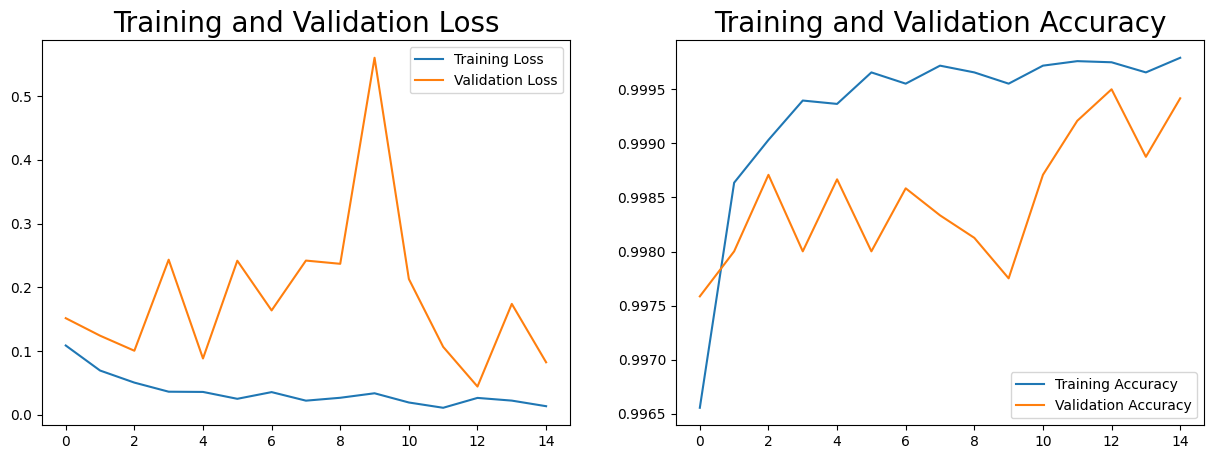

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend()

In [18]:
score, acc = keras_model.evaluate(validation_data)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

751/751 ━━━━━━━━━━━━━━━━━━━━ 116s 154ms/step - accuracy: 0.9996 - loss: 0.0406
Validation Loss = 0.0823429673910141
Validation Accuracy = 0.9994171261787415


#### Predict Test Data

In [19]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    validation_split=None,
)

Found 233 files belonging to 7 classes.


In [20]:
test_score, test_acc = keras_model.evaluate(test_data)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9800 - loss: 2.2181
Test Loss = 3.4999988079071045
Test Accuracy = 0.9699570536613464


#### Loss & Accuracy

In [21]:
accuracy = [('Validation', score, acc), ('Test', test_score, test_acc)]
predict_test = pd.DataFrame(data=accuracy, columns=['Model', 'Loss', 'Accuracy'])
predict_test

,Model,Loss,Accuracy
0,Validation,0.082343,0.999417
1,Test,3.499999,0.969957


#### Save Model

In [57]:
keras_model.save('model_2_16_unknown.keras')

#### Predict Single Image

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [23]:
single_path = os.path.join('input', 'single')

In [24]:
def predict_single(path):
    img = image.load_img(path, target_size=(224, 224))
    
    # Preprocessing
    img = image.img_to_array(img)  # Grayscale
    img = np.expand_dims(img, axis=0)  # 轉換通道
    # img = img / 255  # Rescale
    
    pred = keras_model.predict(img)[0]  # List of probabilities
#     print(pred)
    index = np.argmax(pred)
#     print('Confidence:', max(pred) * 100, '%')
    return train_data.class_names[index]

In [1]:
for dirname, _, filenames in os.walk(single_path):
    for filename in filenames:
        print('Actual:', filename, '\nPredict:', predict_single(os.path.join(dirname, filename)))

### Convolutional Neural Networks

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 14

keras_model = tf.keras.models.Sequential([
    # Preprocessing layers
    tf.keras.layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),  # Fix overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

keras_model.build((None, img_height, img_width, 3))
keras_model.summary()

In [ ]:
keras_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_fit = keras_model.fit(train_data, validation_data=validation_data, epochs=15)

In [ ]:
hist = pd.DataFrame(model_fit.history)
hist

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend()

In [ ]:
score, acc = keras_model.evaluate(validation_data)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

#### Predict Test Data

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    image_size=(img_height, img_width),
    validation_split=None,
)

In [ ]:
test_score, test_acc = keras_model.evaluate(test_data)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

#### Loss & Accuracy

In [ ]:
accuracy = [('Validation', score, acc), ('Test', test_score, test_acc)]
predict_test = pd.DataFrame(data=accuracy, columns=['Model', 'Loss', 'Accuracy'])
predict_test